<a href="https://colab.research.google.com/github/krishnakaushik25/handwritten_digit_recognizer-DL/blob/master/Using_optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

USING SGD,Momentum and L2-regulizer in training process

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import sys
import warnings
warnings.filterwarnings("ignore")

seed = 782
np.random.seed(seed)

In [ ]:
df = pd.read_csv("/content/drive/My Drive/train.csv")
train = df.values

train_y = train[:,0].astype('int8')
train_x = train[:,1:].astype('float64')

train = None

print("Shape Train Images: (%d,%d)" % train_x.shape)
print("Shape Labels: (%d)" % train_y.shape)

Shape Train Images: (42000,784)
Shape Labels: (42000)


In [ ]:
df = pd.read_csv("/content/drive/My Drive/test.csv")
test = df.values.astype('float64')
print("Shape Test Images: (%d,%d)" % test.shape)

Shape Test Images: (28000,784)


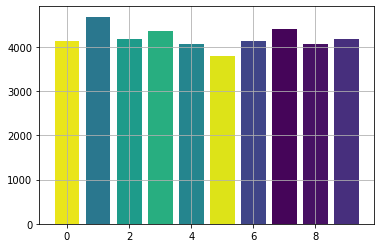

In [ ]:
def count_exemple_per_digit(exemples):
    hist = np.ones(10)

    for y in exemples:
        hist[y] += 1

    colors = []
    for i in range(10):
        colors.append(plt.get_cmap('viridis')(np.random.uniform(0.0,1.0,1)[0]))

    bar = plt.bar(np.arange(10), hist, 0.8, color=colors)

    plt.grid()
    plt.show()

count_exemple_per_digit(train_y)

In [ ]:
def normalization(x, mu, sigma):
    
    x_norm = np.zeros_like(x)

    for n in range(len(x)):
        for j in range(len(x[n])):
            if(sigma[j]!=0):
                x_norm[n,j] = (x[n,j] - mu[j]) / sigma[j]
            else:
                x_norm[n,j] = 0
                    
    return x_norm

In [ ]:
mu = np.mean(train_x, axis=0)
sigma = np.max(train_x, axis=0)-np.min(train_x, axis=0)

In [ ]:
test = normalization(test, mu, sigma)
train_x = normalization(train_x,mu, sigma)

In [ ]:
train_y = pd.get_dummies(train_y).values
print(train_y[0])

[0 1 0 0 0 0 0 0 0 0]


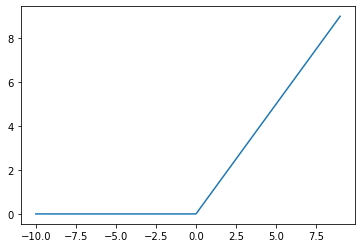

In [ ]:
def ReLu(x, derivative=False):
    if(derivative==False):
        return x*(x > 0)
    else:
        return 1*(x > 0)

x = np.arange(20)-10
relu = ReLu(x)

plt.plot(x, relu)
plt.show()


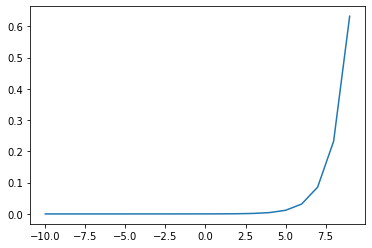

In [ ]:
def Softmax(x):
    x -= np.max(x)
    sm = (np.exp(x).T / np.sum(np.exp(x),axis=1)).T
    return sm

x = np.arange(20)-10
softmax = Softmax([x])

plt.plot(x, softmax[0])
plt.show()

In [ ]:
def CreateWeights():
    ##Initialization of the Weights and the Biases with the random gaussian function with mean zeron, and variance between 1/sqtr(num_inputs_layer)
    
    ninputs = 784
    wl1 = 500 ##Number of neurons in the first layer
    wl2 = 300 ##Number of neurons in the second layer
    nclass = 10 ##Numer of the class, in this case it is the number of the digits.
    
    #layer1
    w1 = np.random.normal(0, ninputs**-0.5, [ninputs,wl1])
    b1 = np.random.normal(0, ninputs**-0.5, [1,wl1])
    
    #Layer2
    w2 = np.random.normal(0, wl1**-0.5, [wl1,wl2])
    b2 = np.random.normal(0, wl1**-0.5, [1,wl2])

    #Layer3
    w3 = np.random.normal(0, wl2**-0.5, [wl2,nclass])
    b3 = np.random.normal(0, wl2**-0.5, [1,nclass])
    
    return [w1,w2,w3,b1,b2,b3]

In [ ]:
def Dropout(x, dropout_percent):
    mask = np.random.binomial([np.ones_like(x)],(1-dropout_percent))[0]  / (1-dropout_percent)
    return x*mask

In [ ]:
def predict(weights, x, dropout_percent=0):
    
    w1,w2,w3,b1,b2,b3  = weights 
    
    #1-Hidden Layer
    first = ReLu(x@w1+b1)
    first = Dropout(first, dropout_percent)

    #2-Hidden Layer
    second = ReLu(first@w2+b2)
    second = Dropout(second, dropout_percent)
    
    #Output Layer
    return [first, second, Softmax(second@w3+b3)]

In [ ]:
def accuracy(output, y):
    hit = 0
    output = np.argmax(output, axis=1)
    y = np.argmax(y, axis=1)
    for y in zip(output, y):
        if(y[0]==y[1]):
            hit += 1

    p = (hit*100)/output.shape[0]
    return p

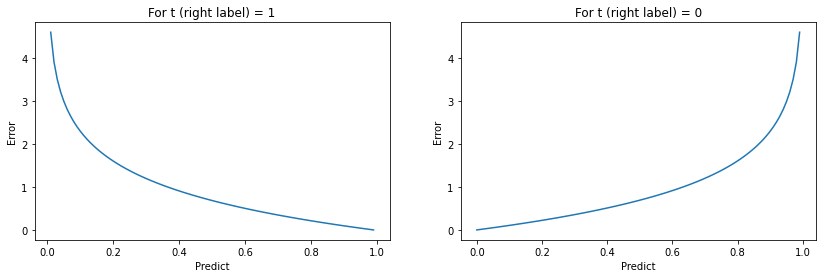

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 4))

y = np.arange(100)/100

e = -np.log(y)
e2 = -np.log(1-y)

ax0.plot(y, e)
ax0.set_title("For t (right label) = 1")
ax0.set_xlabel("Predict")
ax0.set_ylabel("Error")
ax1.plot(y, e2)
ax1.set_title("For t (right label) = 0")
ax1.set_xlabel("Predict")
ax1.set_ylabel("Error")
plt.show()

In [ ]:
def log2(x):
    if(x!=0):
        return np.log(x)
    else:
        return -np.inf
    
def log(y):
    return [[log2(nx) for nx in x]for x in y]

def cost(Y_predict, Y_right, weights, nabla):
    w1,w2,w3,b1,b2,b3  = weights
    weights_sum_square = np.mean(w1**2) + np.mean(w2**2) + np.mean(w3**2)
    Loss = -np.mean(Y_right*log(Y_predict) + (1-Y_right)*log(1-Y_predict)) + nabla/2 *  weights_sum_square
    return Loss

In [ ]:
porcent_valid = 0.1
VALID_SIZE = round(train_x.shape[0]*porcent_valid)

index_data = np.arange(train_x.shape[0])
np.random.shuffle(index_data)

x_train = train_x[index_data[VALID_SIZE:]]
x_valid = train_x[index_data[:VALID_SIZE]]


d_train = train_y[index_data[VALID_SIZE:]]
d_valid = train_y[index_data[:VALID_SIZE]]

train_x = None
train_y = None

x_train.shape

(37800, 784)

In [ ]:
def SGD(weights, x, t, outputs, eta, gamma, nabla, cache=None):
    
    w1,w2,w3,b1,b2,b3  = weights
    
    
    if(cache==None):
            vw1 = np.zeros_like(w1)
            vw2 = np.zeros_like(w2)
            vw3 = np.zeros_like(w3)
            vb1 = np.zeros_like(b1)
            vb2 = np.zeros_like(b2)
            vb3 = np.zeros_like(b3)
    else:
        vw1,vw2,vw3,vb1,vb2,vb3 = cache
    
    first, second, y = outputs
   
    w3_delta = (t-y)
   
    w2_error = w3_delta@w3.T
    
    w2_delta = w2_error * ReLu(second,derivative=True)

    w1_error = w2_delta@w2.T
    w1_delta = w1_error * ReLu(first,derivative=True)
    
    eta = -eta/x.shape[0]
 
    vw3 = gamma*vw3 + eta * (second.T@w3_delta + nabla*w3)
    vb3 = gamma*vb3 + eta * w3_delta.sum(axis=0)

    vw2 = gamma*vw2 + eta * (first.T@w2_delta + nabla*w2)
    vb2 = gamma*vb2 + eta * w2_delta.sum(axis=0)

    vw1 = gamma*vw1 + eta * (x.T@w1_delta + nabla*w1)
    vb1 = gamma*vb1 + eta * w1_delta.sum(axis=0)
    
    
    w3 -= vw3
    b3 -= vb3

    w2 -= vw2
    b2 -= vb2

    w1 -= vw1
    b1 -= vb1
    
    weights = [w1,w2,w3,b1,b2,b3]
    cache = [vw1,vw2,vw3,vb1,vb2,vb3]
    
    return weights, cache

In [ ]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1).reshape(shape)

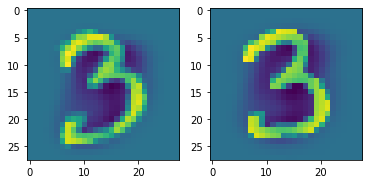

In [ ]:
x_t = np.array([elastic_transform(xx.reshape(28,28),15,3).reshape(784) for xx in x_train[0:10]])
plt.subplot(1,2,1)
plt.imshow(x_t[0].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(x_train[0].reshape(28,28))

In [ ]:

def run(weights, x_train, y_train, x_valid, y_valid, epochs = 10, nbatchs=25, alpha = 1e-3, decay = 0, momentum = 0, l2 = 0.001, dropout_percent = 0):
    
    pross = x_train.shape[0]*0.05
    
    history = [[],[]]
    
    index = np.arange(x_train.shape[0])
    cache = None
    print("Train data: %d" % (x_train.shape[0]))
    print("Validation data: %d \n" % (x_valid.shape[0]))
    mtime = 0
    
    r_weights = []
    max_accuracy_valid = 0
    
    for j in range(epochs):
        np.random.shuffle(index)
        t = 0
        iterations = round(x_train.shape[0]/nbatchs)
        prog = ""
        sacurr = 0
        sloss = 0
        sys.stdout.write("\nEpochs: %2d \ %2d \n"% (j+1,epochs))
        stime = 0
        timeIT = time.time()
        for i in range(iterations):
            timeI = time.time()
            f = i*nbatchs
            l = f+nbatchs
            
            if(l>(x_train.shape[0]-1)):
                l = x_train.shape[0]
                
            x = np.array([elastic_transform(xx.reshape(28,28),15,3).reshape(784) for xx in x_train[index[f:l]]])
            y = y_train[index[f:l]]

            outputs = predict(weights, x, dropout_percent)
            
            loss = cost(outputs[-1], y, weights, l2)
            
            
            accuracy_t = accuracy(outputs[-1], y)
            
            sacurr += accuracy_t
            sloss += loss
            
            accuracy_train = sacurr/(i+1)
            loss_train = sloss/(i+1)
            
            weights, cache = SGD(weights, x, y, outputs, alpha, momentum, l2, cache)
            
            t+= x.shape[0]
            
            qtd = round(t/pross)
            prog = "["
            for p in range(20):
                if(p<qtd-1):
                    prog += "="
                elif(p==qtd-1):
                    prog += ">"
                else:
                    prog += "."
            prog += "]"

            
            stime += time.time()-timeI
            mtime = stime/(i+1)
            mTimeT = mtime * (iterations-i-1)
            
            sys.stdout.write("\r%5d/%5d %s ETA: %3d s - loss: %.4f  acc: %.4f" % (t, x_train.shape[0], prog, mTimeT, loss_train, accuracy_train))
            
            history[0].append([loss_train, accuracy_train])
        mtime = time.time()-timeIT
        alpha = alpha - (alpha*decay)
        
        outputs = predict(weights, x_valid)
        
        loss_valid = cost(outputs[-1], y_valid, weights, l2)
        accuracy_valid = accuracy(outputs[-1], y_valid)
        
        sys.stdout.write("\r%5d/%5d %s ETA: %3d s loss: %.4f  acc: %.4f - lossValid: %.4f  accValid: %.4f " % ( t, x_train.shape[0], prog, mtime, loss_train, accuracy_train, loss_valid, accuracy_valid))
        history[1].append([loss_valid, accuracy_valid])
            
        if(accuracy_valid>=max_accuracy_valid):
            w1,w2,w3,b1,b2,b3  = weights
            r_weights = [w1.copy(),w2.copy(),w3.copy(),b1.copy(),b2.copy(),b3.copy()]
            max_accuracy_valid = accuracy_valid
        
    return r_weights, history

In [ ]:
weights = CreateWeights()

alpha = 5e-2
epochs = 40
nbatchs = 100
weights, history = run(weights, 
              x_train, d_train, 
              x_valid, d_valid, 
              epochs = epochs,
              nbatchs=nbatchs, 
              alpha = alpha, 
              decay = 0.05, 
              momentum = 0.9, 
              l2 = 1e-3, 
              dropout_percent = 0.20)

Train data: 37800
Validation data: 4200 


Epochs:  1 \ 40 
37800/37800 [===================>] ETA:  60 s loss: 0.0887  acc: 83.2143 - lossValid: 0.0264  accValid: 95.4048 
Epochs:  2 \ 40 
37800/37800 [===================>] ETA:  60 s loss: 0.0461  acc: 91.5979 - lossValid: 0.0185  accValid: 96.7381 
Epochs:  3 \ 40 
37800/37800 [===================>] ETA:  61 s loss: 0.0387  acc: 93.0238 - lossValid: 0.0158  accValid: 97.3095 
Epochs:  4 \ 40 
37800/37800 [===================>] ETA:  60 s loss: 0.0331  acc: 94.1296 - lossValid: 0.0132  accValid: 97.5476 
Epochs:  5 \ 40 
37800/37800 [===================>] ETA:  61 s loss: 0.0308  acc: 94.5106 - lossValid: 0.0125  accValid: 97.7143 
Epochs:  6 \ 40 
37800/37800 [===================>] ETA:  61 s loss: 0.0282  acc: 94.8598 - lossValid: 0.0104  accValid: 98.1429 
Epochs:  7 \ 40 
37800/37800 [===================>] ETA:  61 s loss: 0.0273  acc: 95.1640 - lossValid: 0.0097  accValid: 98.2381 
Epochs:  8 \ 40 
37800/37800 [=================

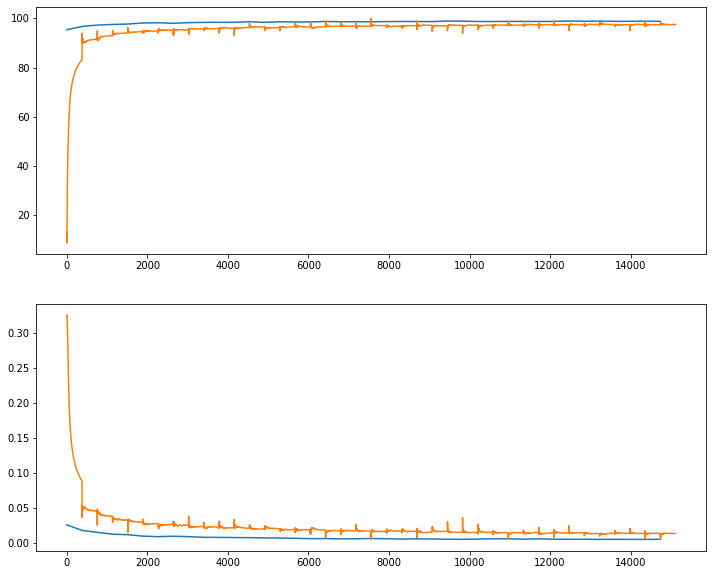

In [ ]:
train_history = np.array(history[0])
t_loss = train_history[:,:1]
t_acc = train_history[:,1:2]
valid_history = np.array(history[1])
train_history.shape
v_loss = valid_history[:,:1]
v_acc = valid_history[:,1:2]
plt.figure(figsize=(12,10))

plt.subplot(2, 1, 1)
x = np.arange(epochs)*int(x_train.shape[0]/nbatchs)
plt.plot(x,v_acc)
plt.plot(t_acc)

plt.subplot(2, 1, 2)
plt.plot(x,v_loss)
plt.plot(t_loss)

plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
outputs = predict(weights, x_valid)

In [ ]:
p = np.argmax(outputs[-1],axis=1)
predict_dummies = pd.get_dummies(p).values.astype('int8')

cm = np.zeros((10,10)).astype(np.int64)

d_valid_int = np.argmax(d_valid, axis=1)

for i in range(predict_dummies.shape[0]):
    cm[d_valid_int[i]] += predict_dummies[i]

print(cm)

[[430   1   0   0   0   1   1   0   0   0]
 [  0 457   0   0   1   0   0   3   0   0]
 [  0   0 418   0   0   0   0   2   0   0]
 [  0   0   1 433   0   1   0   3   1   2]
 [  0   1   0   0 405   0   0   3   0   0]
 [  0   0   0   2   0 364   4   1   1   1]
 [  0   0   0   0   0   0 401   0   0   0]
 [  0   1   2   0   0   0   0 427   0   0]
 [  1   0   0   0   1   2   0   0 414   1]
 [  0   1   0   0   4   0   0   1   0 407]]


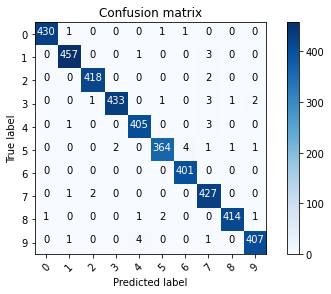

In [ ]:
plot_confusion_matrix(cm, range(10))

In [ ]:
s_cm = np.sum(cm,axis=0)
for i in range(10):
    p = cm[i][i]/s_cm[i]
    print("%d - %.3f %%" % (i,p))

print(" ");
print("%f %%" % accuracy(outputs[-1], d_valid))

0 - 0.998 %
1 - 0.991 %
2 - 0.993 %
3 - 0.995 %
4 - 0.985 %
5 - 0.989 %
6 - 0.988 %
7 - 0.970 %
8 - 0.995 %
9 - 0.990 %
 
98.952381 %


In [ ]:
outputs = predict(weights, test)

In [ ]:
d = np.argmax(outputs[-1],axis=1)

In [ ]:
#ImageId,Label

pd.DataFrame({"ImageId": list(range(1,len(d)+1)), "Label": d}).to_csv('output.csv', index=False, header=True)

/content/output.csv this is the file of outputs